Implemenation and notes of backpropagation in its simplest form.

Backpropagation is essentially applying chain rule on your function. Gets the derivative of each variable, determing the impact of each variable on the overall output. 

Neural nets are the large scale operation of backprop, essentially iterating upon mathematical expressions.

In [16]:
import math
import numpy as np

In [17]:
class Value:
  #constructor
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
      
  #string representation
  def __repr__(self):
    return f"Value(data={self.data})"

  #add operator
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+') 
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out 

In [18]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [22]:
f.grad = 4; #L = d*f and d = e+c = 4
d.grad = -2 #L = d*f and f = -2
L.grad = 1

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

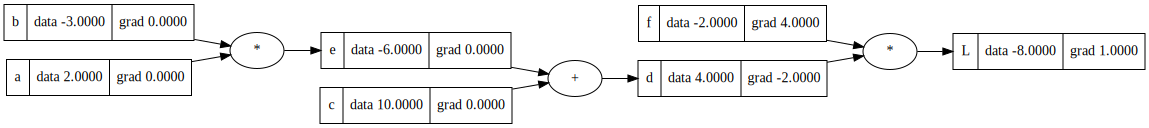

In [24]:
draw_dot(L)

We manually calculate first order derivative dL/dd and dL/df. 

Now we need to calculate dL/de and dL/dc

This invokes chain rule. We leverage the already known gradients dL/dd and dL/df.

dL/de = dL/dd * dd/de = -2 * dd/de

and dL/dc = dL/dd * dd/dc = 4 * dd/dc

We must solve for the two remaining terms by calculating their first order derivative.

d = e+c

dd/de = 1 (e is a linear function)
dL/de = dL/de = dL/dd * dd/de = -2 * dd/de = -2 * 1 = -2

dd/dc = 1 (c is also a linear function)
dL/dc = dL/dd * dd/dc = -2 * dd/dc = -2 * 1 = -2

In [25]:
e.grad = -2
c.grad = -2

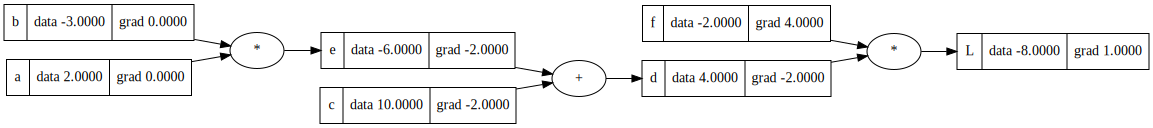

In [26]:
draw_dot(L)

now we need dL/db and dL/da.

for brevity, we can spell out the entire chain rule algorithm here.

dL/db = dL/dd * dd/de * de/db  
dL/da = dL/dd * dd/de * de/da 

We know dL/dd * dd/de = -2 from our last expression (this is also e.grad)

dL/db = -2 * de/db 
dL/da = -2 * de/da

e = a*b
de/da = b = -3
de/db = a = 2 

dL/db = -2 * de/db = -2 * 2  = -4  
dL/da = -2 * de/da = -2 * - 3= 6 

In [27]:
b.grad = -4
a.grad = 6

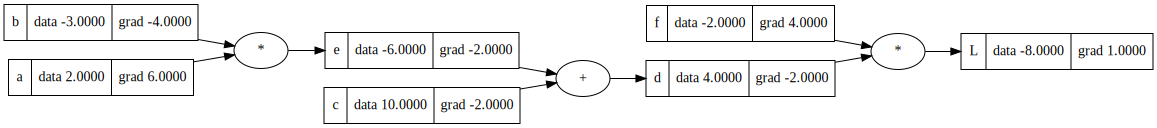

In [28]:
draw_dot(L)